In [14]:
# Import von Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

## Übung 2.1

##### Input-Parameter:

In [15]:
# Input - Parameter
Pv_kWp = 10
Zinssatz = 0.06
Systemkosten = 800
Betriebskosten = 10     #€/(kWp a)
Lebensdauer = 20        #Jahre

##### Einlesen der gewünschten Daten

In [16]:
#Normierte PV-Einspeisung
dfEinspeisung = pd.read_csv("PV_Einspeisung.csv")

#Preise 2023 (ct/kWh)
dfPeise = pd.read_csv("ENTSOE_prices_for_2023_in_ct_per_kWh.csv", delimiter =";")

#Auswahl des Landes
Preise = dfPeise["AT"]

##### a.) Barwert berechnen

In [17]:
def Barwert_ohne_OeMAG(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer):
    
    #Erlös
    Erlöse_array = dfEinspeisung["0"] * Pv_kWp / 100 * Preise
    Erlöse = np.sum(Erlöse_array)
    
    #Nettobarwertmethode (NPV) ohne OEMAG
    NPV = np.zeros(shape=(Lebensdauer,1))
    time = np.arange(1, Lebensdauer)
    NPV[0][0] = -Pv_kWp*Systemkosten          #Investitionskosten zum Zeitpunkt 0 in EUR
    NPV[1:, 0] = NPV[0][0] + np.cumsum((Erlöse - Betriebskosten) / ((1 + Zinssatz) ** time))

    #Alternative:
    #for i in range(19):
        #NPV[i+1][0] = NPV[i][0] + (Erlöse - Betriebskosten)/((1+Zinssatz)**(i+1))

    fig, ax = plt.subplots()
    ax.bar(np.arange(1, 21), NPV.flatten(), zorder=2)
    ax.set_title("Barwertberechnung ohne OeMag")
    ax.set_xlabel('t in Years')
    ax.set_ylabel('Yield in €')
    ax.grid(True, zorder=1)
    plt.show()
    

##### b.) Barwert berechnen mit OeMAG:

In [18]:
def Barwert_mit_OeMAG(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer):
    
    #Erlös
    Erlöse_array = dfEinspeisung["0"] * Pv_kWp / 100 * Preise
    Erlöse = np.sum(Erlöse_array)
    
    #Nettobarwertmethode (NPV) ohne OEMAG
    NPV = np.zeros(shape=(Lebensdauer,1))
    time = np.arange(1, Lebensdauer)
    
    #Investitionskosten zum Zeitpunkt 0 in EUR
    NPV[0][0] = -Pv_kWp*Systemkosten + np.minimum(195*Pv_kWp,(0.3*Pv_kWp*Systemkosten)) 
    NPV[1:, 0] = NPV[0][0] + np.cumsum((Erlöse - Betriebskosten) / ((1 + Zinssatz) ** time))
    
    fig, ax = plt.subplots()
    ax.bar(np.arange(1, 21), NPV.flatten(), zorder=2)
    ax.set_title("Barwertberechnung mit OeMag")
    ax.set_xlabel('t in Years')
    ax.set_ylabel('Yield in €')
    ax.grid(True, zorder=1)
    plt.show()

##### c.) Barwert mit normierten Preisen:

In [19]:
def Barwert_ohne_OeMAG_Normiert(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer):

    #Durchschnittspreis über das gesamter Jahr
    Preise_NORM = np.mean(Preise)

    #Erlöse berechnen
    Erlöse_array = dfEinspeisung["0"] * Pv_kWp / 100 * Preise_NORM
    Erlöse = np.sum(Erlöse_array)
    
    #Nettobarwertmethode (NPV) ohne OEMAG mit normierten Preis
    NPV = np.zeros(shape=(Lebensdauer,1))
    time = np.arange(1, Lebensdauer)
    
    #Investitionskosten zum Zeitpunkt 0 in EUR
    NPV[0][0] = -Pv_kWp*Systemkosten 
    NPV[1:, 0] = NPV[0][0] + np.cumsum((Erlöse - Betriebskosten) / ((1 + Zinssatz) ** time))
    
    fig, ax = plt.subplots()
    ax.bar(np.arange(1, 21), NPV.flatten(), zorder=2)
    ax.set_title("Barwertberechnung ohne OeMag mit normierten Preisen")
    ax.set_xlabel('t in Years')
    ax.set_ylabel('Yield in €')
    ax.grid(True, zorder=1)
    plt.show()

In [20]:
def Barwert_mit_OeMAG_Normiert(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer):
    
    #Durchschnittspreis über das gesamter Jahr
    Preise_NORM = np.mean(Preise)

    #Erlöse berechnen
    Erlöse_array = dfEinspeisung["0"] * Pv_kWp / 100 * Preise_NORM
    Erlöse = np.sum(Erlöse_array)
    
    #Nettobarwertmethode (NPV) ohne OEMAG mit normierten Preis
    NPV = np.zeros(shape=(Lebensdauer,1))
    time = np.arange(1, Lebensdauer)#Nettobarwertmethode (NPV) mit OEMAG
    NPV[0][0] = -Pv_kWp*Systemkosten + np.minimum(195*Pv_kWp,(0.3*Pv_kWp*Systemkosten))
    NPV[1:, 0] = NPV[0][0] + np.cumsum((Erlöse - Betriebskosten) / ((1 + Zinssatz) ** time))

    fig, ax = plt.subplots()
    ax.bar(np.arange(1, 21), NPV.flatten(), zorder=2)
    ax.set_title("Barwertberechnung mit OeMag mit normierten Preisen")
    ax.set_xlabel('t in Years')
    ax.set_ylabel('Yield in €')
    ax.grid(True, zorder=1)
    plt.show()

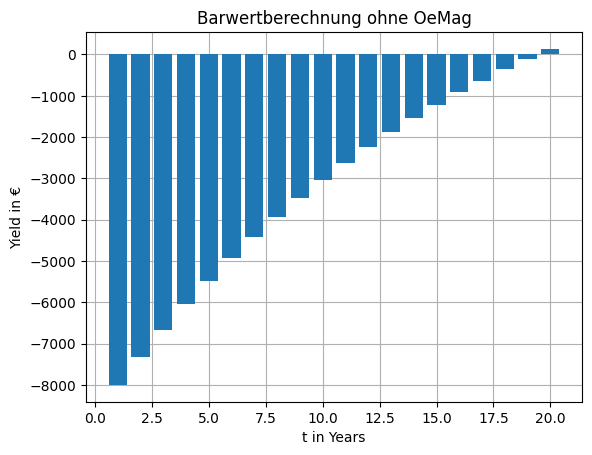

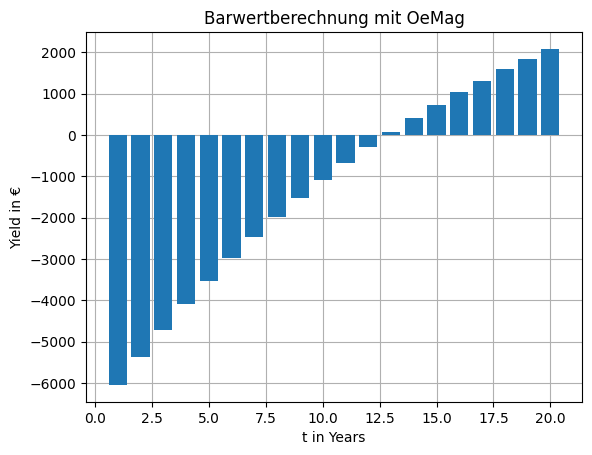

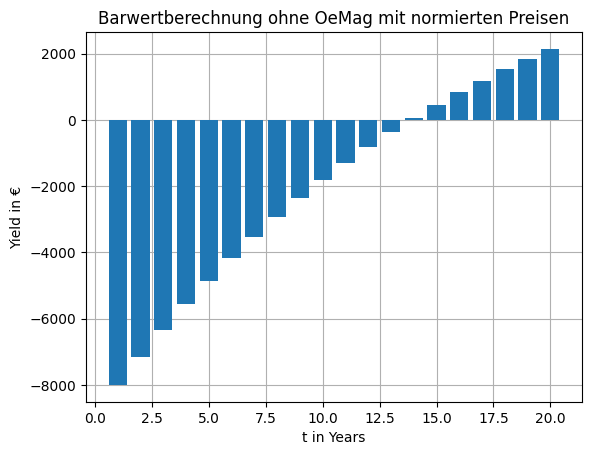

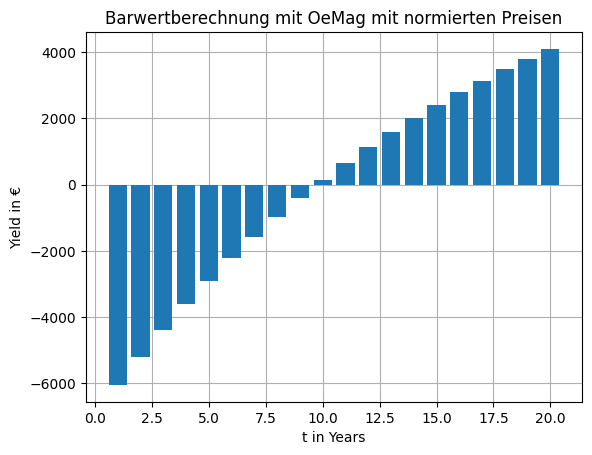

In [21]:
Barwert_ohne_OeMAG(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer)
Barwert_mit_OeMAG(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer)
Barwert_ohne_OeMAG_Normiert(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer)
Barwert_mit_OeMAG_Normiert(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer)

## Übung 2.2

##### Input-Parameter & gewünschte Daten:

In [22]:
Pv_kWp = 5
dfProduktion = pd.read_csv("PV_Profil_leistung_2.csv")  #Produktion der Anlage
dfVerbrauch = pd.read_csv("LeistungHaushalte.csv")
dfVerbrauch_kWh = dfVerbrauch / 1000                    #Umrechnung Wh in kWh

#Auswählen Verbrauch vom gewünschten Haushalt:
Haushalt1 = dfVerbrauch_kWh["1"]
Haushalt2 = dfVerbrauch_kWh["2"]


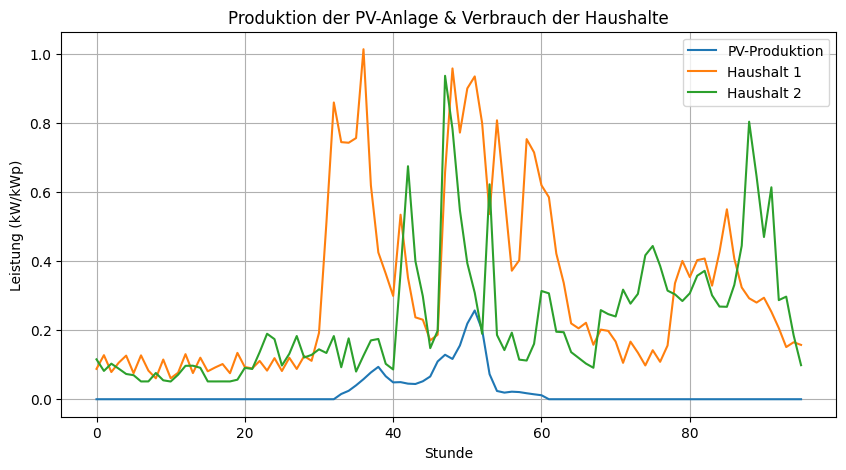

In [23]:
########################################
# Test zur leichteren Veranschaulichung
# Auswählen der ersten 96 Werte (einen Tag) (01.01.2023)
dfProduktion_day = dfProduktion.head(96)
dfVerbrauch_day = dfVerbrauch_kWh.head(96)

# Plot Produktion der PV-Anlage & Verbrauchsdaten der Haushalte
plt.figure(figsize=(10, 5))
plt.plot(dfProduktion_day["Produktion"], label="PV-Produktion")
plt.plot(dfVerbrauch_day["1"], label="Haushalt 1")
plt.plot(dfVerbrauch_day["2"], label="Haushalt 2")
plt.xlabel("Stunde")
plt.ylabel("Leistung (kW/kWp)")
plt.title("Produktion der PV-Anlage & Verbrauch der Haushalte")
plt.legend()
plt.grid(True)
plt.show()


##### a.) Eigenverbrauch & Überschusseinspeisung:

In [24]:
def Eigenverbrauch_Einspeisung_Haushalt(Haushalt, dfProduktion, Pv_kWp):
    
    Eigenverbrauch = 0
    Einspeisung = 0
    
    # Schleife über die Stunden des Tages
    for i in range(len(dfProduktion)):
        # Berechne den erzeugten Strom der PV-Anlage für diese Stunde
        erzeugte_energie = dfProduktion.iloc[i]["Produktion"] * Pv_kWp
        
        # Berechne den Eigenverbrauch und die Einspeisung für diese Stunde
        if Haushalt[i] >= erzeugte_energie:
            Eigenverbrauch += erzeugte_energie
        else:
            Eigenverbrauch += Haushalt[i]
            Einspeisung += erzeugte_energie - Haushalt[i]
    
    return Eigenverbrauch, Einspeisung

In [25]:
# Berechne Eigenverbrauch und Einspeisung für Haushalt 1
Eigenverbrauch1, Einspeisung1 = Eigenverbrauch_Einspeisung_Haushalt(Haushalt1, dfProduktion, Pv_kWp)
print("Gesamteigenverbrauch Haushalt 1:", Eigenverbrauch1, "kWh")
print("Gesamteinspeisung Haushalt 1:", Einspeisung1, "kWh")

# Berechne Eigenverbrauch und Einspeisung für Haushalt 2
Eigenverbrauch2, Einspeisung2 = Eigenverbrauch_Einspeisung_Haushalt(Haushalt2, dfProduktion, Pv_kWp)
print("Gesamteigenverbrauch Haushalt 2:", Eigenverbrauch2, "kWh")
print("Gesamteinspeisung Haushalt 2:", Einspeisung2, "kWh")

Gesamteigenverbrauch Haushalt 1: 3282.1328091265 kWh
Gesamteinspeisung Haushalt 1: 15740.346546000026 kWh
Gesamteigenverbrauch Haushalt 2: 2450.651141626509 kWh
Gesamteinspeisung Haushalt 2: 16571.828213499994 kWh


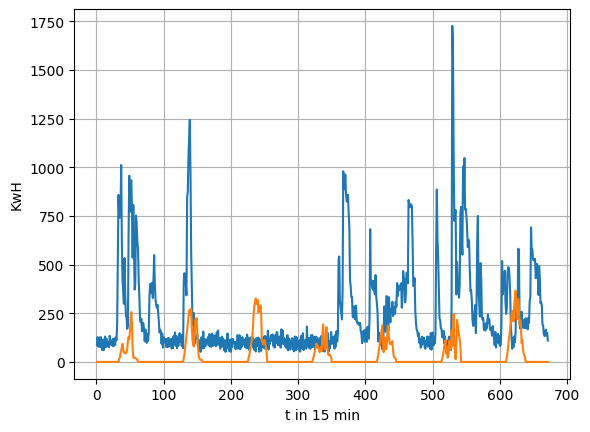

In [26]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, 672), dfVerbrauch["1"][0:671])
ax.plot(np.arange(1, 672), dfProduktion["Produktion"][0:671]*1000)
ax.set_title("")
ax.set_xlabel('t in 15 min')
ax.set_ylabel('KwH')
ax.grid(True, zorder=1)
plt.show()